In [1]:
# Import necessary libraries
import os, glob, collections, pathlib, re
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=False)


Mounted at /content/drive


# **Data Preprocessing and Visualization**

---



In [3]:
#Find and Identify CSV files in Drive
acc_files = glob.glob("/content/drive/MyDrive/**/Accelerometer*.csv", recursive=True)
gyr_files = glob.glob("/content/drive/MyDrive/**/Gyroscope*.csv",    recursive=True)

print(f"Found Accelerometer files: {len(acc_files)}")
print(f"Found Gyroscope files    : {len(gyr_files)}")

activity_dirs = set()
for p in acc_files + gyr_files:
    dirpath = os.path.dirname(p)
    leaf = os.path.basename(dirpath).lower()
    if leaf in {"jump","standing","still","walk","walking","jumping"}:
        activity_dirs.add(dirpath)

if not activity_dirs:
    raise SystemExit("Couldn't find activity folders named jump/standing/still/walk with Accelerometer/Gyroscope CSVs.")

bases = [str(pathlib.Path(d).parent) for d in activity_dirs]
counter = collections.Counter(bases)
DATA_DIR = counter.most_common(1)[0][0]

print("\n Using DATA_DIR:", DATA_DIR)
subfolders = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Activity subfolders under DATA_DIR:", subfolders)



Found Accelerometer files: 50
Found Gyroscope files    : 50

 Using DATA_DIR: /content/drive/MyDrive/hmm_activity/data
Activity subfolders under DATA_DIR: ['still', 'standing', 'jump', 'walk', 'merged']


In [4]:
#Show file and Print Output(merged) folder
bases = [str(pathlib.Path(d).parent) for d in activity_dirs]
counter = collections.Counter(bases)
DATA_DIR = counter.most_common(1)[0][0]

print("\n Using DATA_DIR:", DATA_DIR)
subfolders = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Activity subfolders under DATA_DIR:", subfolders)

for act in sorted(subfolders):
    if act.lower() not in {"jump","standing","still","walk","walking","jumping"}:
        continue
    ex_acc = glob.glob(os.path.join(DATA_DIR, act, "Accelerometer*.csv"))[:3]
    ex_gyr = glob.glob(os.path.join(DATA_DIR, act, "Gyroscope*.csv"))[:3]
    print(f"\n[{act}] examples:")
    print("  Accelerometer:", [os.path.basename(p) for p in ex_acc])
    print("  Gyroscope   :", [os.path.basename(p) for p in ex_gyr])

merged_dir = os.path.join(DATA_DIR, "merged")
os.makedirs(merged_dir, exist_ok=True)
print("\nOutput folder for merged files will be:", merged_dir)





 Using DATA_DIR: /content/drive/MyDrive/hmm_activity/data
Activity subfolders under DATA_DIR: ['still', 'standing', 'jump', 'walk', 'merged']

[jump] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

[standing] examples:
  Accelerometer: ['Accelerometer(10).csv', 'Accelerometer(11).csv', 'Accelerometer(12).csv']
  Gyroscope   : ['Gyroscope(10).csv', 'Gyroscope(11).csv', 'Gyroscope(12).csv']

[still] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

[walk] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

Output folder for merged files will be: /content/drive/MyDrive/hmm_activity/data/merged


In [5]:
import os, re, glob
import pandas as pd

def natural_sort_key(p):
    b = os.path.basename(p)
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', b)]

def clean_df(df, prefix: str):
    # normalize headers
    df = df.rename(columns={c: c.strip().lower() for c in df.columns})

    # map possible time headers → 'seconds_elapsed'
    aliases = {
        'seconds elapsed': 'seconds_elapsed',
        'elapsed': 'seconds_elapsed',
        'elapsed(s)': 'seconds_elapsed',
        'time(s)': 'seconds_elapsed',
        'time (s)': 'seconds_elapsed',
        'timestamp': 'seconds_elapsed',
        'time': 'seconds_elapsed'
    }
    for k, v in aliases.items():
        if k in df.columns and 'seconds_elapsed' not in df.columns:
            df.rename(columns={k: v}, inplace=True)

    if 'seconds_elapsed' not in df.columns:
        raise ValueError("No 'seconds_elapsed' (time) column found!")

    # keep only time + present axes
    axes = [c for c in ['x', 'y', 'z'] if c in df.columns]
    keep = ['seconds_elapsed'] + axes
    df = df[keep].copy()

    # numeric + drop non-numeric
    df['seconds_elapsed'] = pd.to_numeric(df['seconds_elapsed'], errors='coerce')
    for ax in axes:
        df[ax] = pd.to_numeric(df[ax], errors='coerce')

    df = df.dropna(subset=['seconds_elapsed'])

    # resolve duplicate timestamps (average)
    if df['seconds_elapsed'].duplicated().any():
        df = df.groupby('seconds_elapsed', as_index=False).mean(numeric_only=True)

    # prefix axes: x→acc_x / gyro_x, etc.
    ren = {ax: f'{prefix}_{ax}' for ax in axes}
    df = df.rename(columns=ren).sort_values('seconds_elapsed').reset_index(drop=True)
    return df

def merge_acc_gyro(acc_path, gyro_path, fs: float = 100.0):
    """
    Align accelerometer and gyroscope by nearest timestamp.
    fs = expected sampling rate (Hz). Tolerance = 0.5/fs seconds (≈ half a sample).
    """
    acc  = clean_df(pd.read_csv(acc_path), 'acc')
    gyro = clean_df(pd.read_csv(gyro_path), 'gyro')

    # half-sample tolerance
    tol = 0.5 / fs

    merged = pd.merge_asof(
        acc, gyro,
        on='seconds_elapsed',
        direction='nearest',
        tolerance=tol
    )

    # require gyro present
    for col in ['gyro_x','gyro_y','gyro_z']:
        if col not in merged.columns:
            raise ValueError(f"Missing column after merge: {col}")
    merged = merged.dropna(subset=['gyro_x','gyro_y','gyro_z']).reset_index(drop=True)

    return merged


In [6]:
# one-time setup
OUT_DIR = os.path.join(DATA_DIR, "merged")
os.makedirs(OUT_DIR, exist_ok=True)

# MERGE ALL ACTIVITIES
activities = [d for d in os.listdir(DATA_DIR)
              if os.path.isdir(os.path.join(DATA_DIR, d)) and d.lower() != 'merged']
activities = sorted(activities, key=str.lower)

total_saved = 0
for act in activities:
    folder = os.path.join(DATA_DIR, act)

    acc_files  = [p for p in glob.glob(os.path.join(folder, "Accelerometer*.csv"))
                  if "Uncalibrated" not in os.path.basename(p)]
    gyro_files = [p for p in glob.glob(os.path.join(folder, "Gyroscope*.csv"))
                  if "Uncalibrated" not in os.path.basename(p)]

    acc_files.sort(key=natural_sort_key)
    gyro_files.sort(key=natural_sort_key)

    n = min(len(acc_files), len(gyro_files))
    if n == 0:
        print(f"No calibrated pairs in '{act}'.")
        continue

    print(f"\n{act}: pairing {n} file(s)")
    for i in range(n):
        acc_path, gyro_path = acc_files[i], gyro_files[i]
        try:
            merged = merge_acc_gyro(acc_path, gyro_path, fs=100.0)  # your app used 100 Hz
            merged = merged.rename(columns={"seconds_elapsed": "timestamp"})
            merged["activity"] = act.lower()

            out_name = f"{act.lower()}_{i+1:02d}_merged.csv"
            out_path = os.path.join(OUT_DIR, out_name)
            merged.to_csv(out_path, index=False)

            print(f"  Saved {out_name} | rows={merged.shape[0]}")
            total_saved += 1
        except Exception as e:
            print(f"  Failed on {os.path.basename(acc_path)} + {os.path.basename(gyro_path)} → {e}")

print(f"\nDone. Wrote {total_saved} clean merged file(s) to: {OUT_DIR}")



jump: pairing 11 file(s)
  Saved jump_01_merged.csv | rows=964
  Saved jump_02_merged.csv | rows=766
  Saved jump_03_merged.csv | rows=828
  Saved jump_04_merged.csv | rows=894
  Saved jump_05_merged.csv | rows=948
  Saved jump_06_merged.csv | rows=696
  Saved jump_07_merged.csv | rows=713
  Saved jump_08_merged.csv | rows=740
  Saved jump_09_merged.csv | rows=760
  Saved jump_10_merged.csv | rows=802
  Saved jump_11_merged.csv | rows=770

standing: pairing 16 file(s)
  Saved standing_01_merged.csv | rows=704
  Saved standing_02_merged.csv | rows=789
  Saved standing_03_merged.csv | rows=864
  Saved standing_04_merged.csv | rows=868
  Saved standing_05_merged.csv | rows=866
  Saved standing_06_merged.csv | rows=853
  Saved standing_07_merged.csv | rows=930
  Saved standing_08_merged.csv | rows=893
  Saved standing_09_merged.csv | rows=874
  Saved standing_10_merged.csv | rows=998
  Saved standing_11_merged.csv | rows=941
  Saved standing_12_merged.csv | rows=906
  Saved standing_13_me

In [7]:
import glob, os
import pandas as pd
from collections import defaultdict

# List all merged CSV files
files = glob.glob(os.path.join(OUT_DIR, "*.csv"))
print("Total merged files:", len(files))
print("By activity:", {act: len([f for f in files if act in f]) for act in ["walk","jump","standing","still"]})

# Calculate total duration per activity and overall total
totals = defaultdict(float)
overall_total = 0.0
for f in files:
    df = pd.read_csv(f)
    duration = df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]
    activity = df["activity"].iloc[0]
    totals[activity] += duration
    overall_total += duration


print("Total duration (seconds):", overall_total)

# Inspect one sample merged file
file_path = "/content/drive/MyDrive/hmm_activity/data/merged/walk_01_merged.csv"
df = pd.read_csv(file_path)
print("Columns:", df.columns.tolist())
print(df.head())
print("\nShape:", df.shape)


Total merged files: 50
By activity: {'walk': 12, 'jump': 11, 'standing': 16, 'still': 11}
Total duration (seconds): 410.25768554687494
Columns: ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'activity']
   timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  \
0   0.125790 -0.380257 -1.291761  0.928064 -0.154038 -0.069955 -0.075762   
1   0.135760 -0.425052 -1.204029  0.895139 -0.183276 -0.184780 -0.123934   
2   0.145729 -0.491776 -1.207940  0.926954 -0.156648 -0.261808 -0.165420   
3   0.155699 -0.493656 -1.124904  0.903090 -0.103471 -0.323289 -0.193940   
4   0.165667 -0.529746 -1.029194  0.906623 -0.050747 -0.382712 -0.231503   

  activity  
0     walk  
1     walk  
2     walk  
3     walk  
4     walk  

Shape: (654, 8)


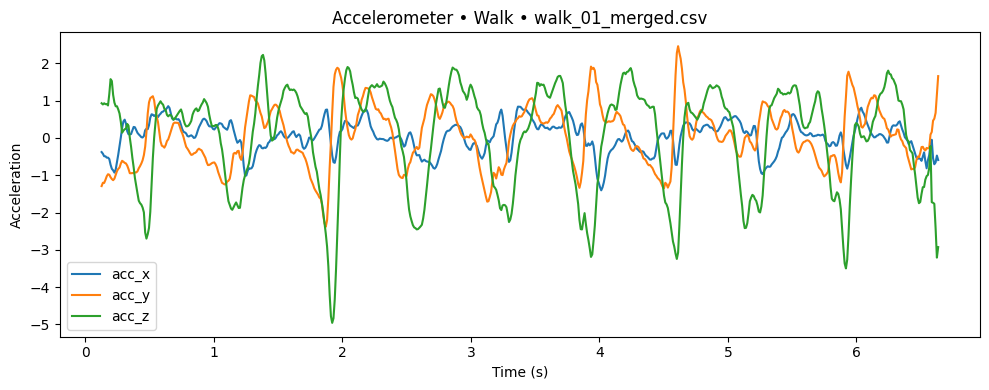

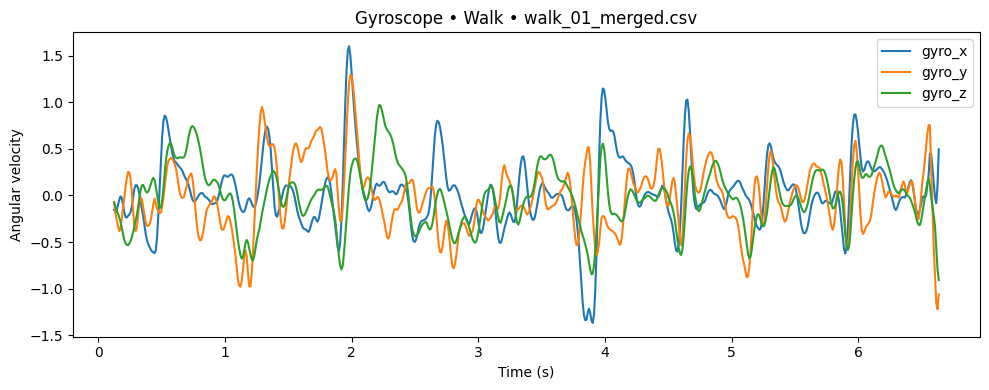

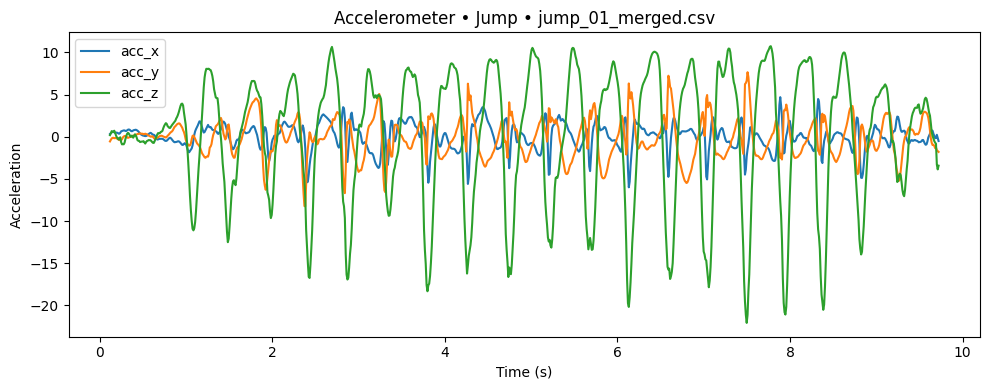

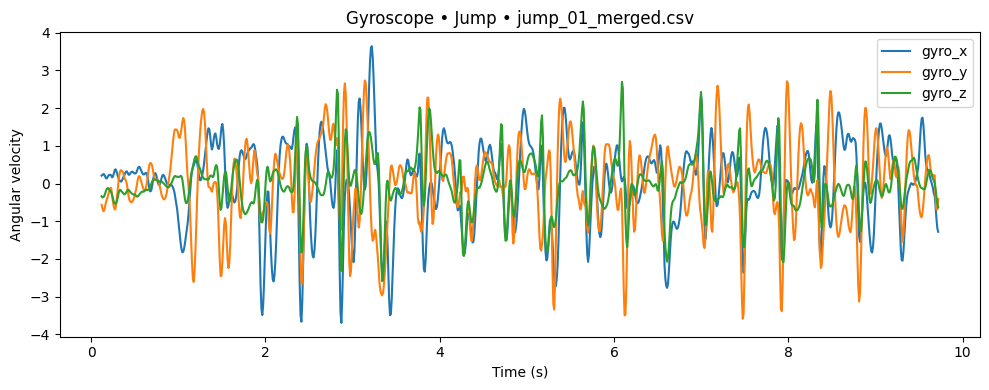

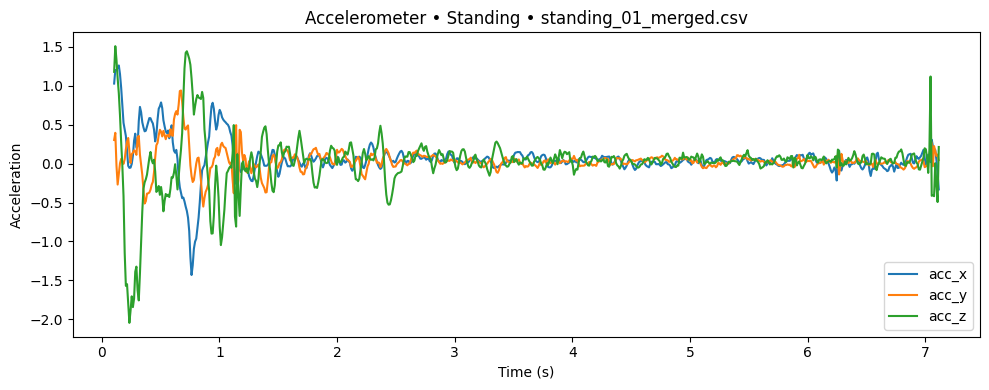

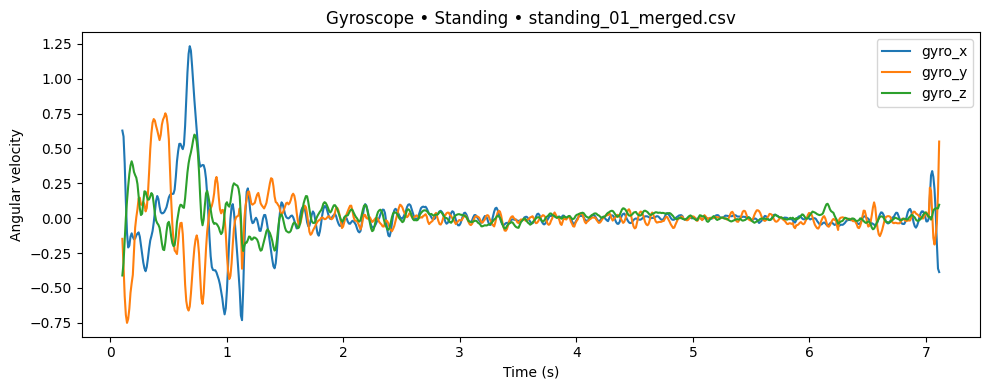

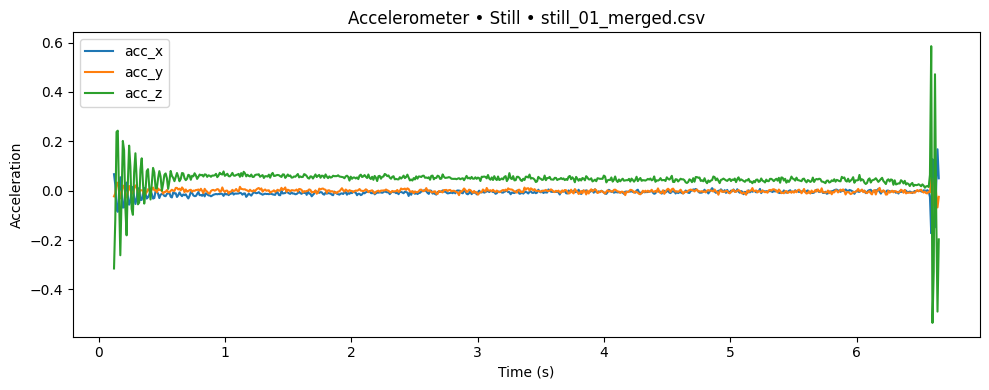

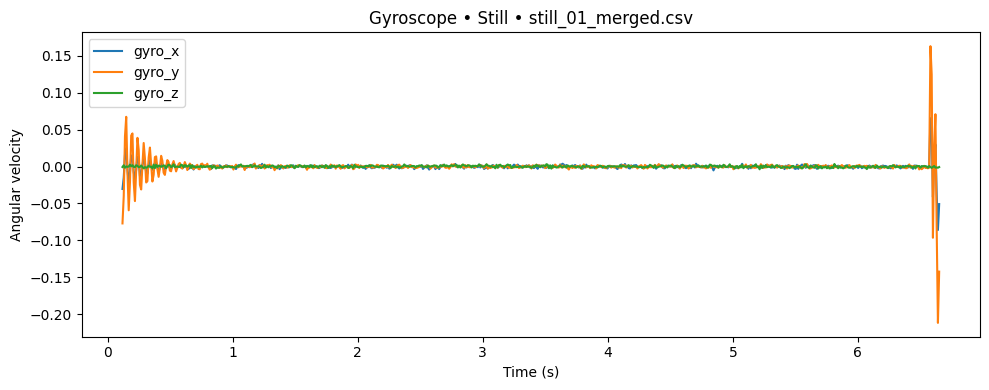

In [8]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

activities = ["walk", "jump", "standing", "still"]

for act in activities:
    pattern = os.path.join(OUT_DIR, f"{act}_*.csv")
    matches = sorted(glob.glob(pattern))
    if not matches:
        print(f"[WARN] No merged files found for activity: {act} (pattern: {pattern})")
        continue

    f = matches[0]  # take the first file for this activity
    df = pd.read_csv(f).sort_values("timestamp")
    act_title = act.capitalize()
    base = os.path.basename(f)

    # Accelerometer plot
    plt.figure(figsize=(10, 4))
    if "acc_x" in df: plt.plot(df["timestamp"], df["acc_x"], label="acc_x")
    if "acc_y" in df: plt.plot(df["timestamp"], df["acc_y"], label="acc_y")
    if "acc_z" in df: plt.plot(df["timestamp"], df["acc_z"], label="acc_z")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration")
    plt.title(f"Accelerometer • {act_title} • {base}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gyroscope plot
    plt.figure(figsize=(10, 4))
    if "gyro_x" in df: plt.plot(df["timestamp"], df["gyro_x"], label="gyro_x")
    if "gyro_y" in df: plt.plot(df["timestamp"], df["gyro_y"], label="gyro_y")
    if "gyro_z" in df: plt.plot(df["timestamp"], df["gyro_z"], label="gyro_z")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity")
    plt.title(f"Gyroscope • {act_title} • {base}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# **Feature Extraction**

In [9]:
#Step 1 — Windowing + Time-Domain Features
import os, glob
import numpy as np
import pandas as pd

# CONFIG
WINDOW_SEC = 2.0   # 2 seconds (≈200 samples @ 100 Hz)
STEP_SEC   = 1.0   # 50% overlap

# HELPERS
def estimate_fs(ts):
    ts = np.asarray(ts, dtype=float)
    dts = np.diff(ts)
    dts = dts[np.isfinite(dts) & (dts > 0)]
    if len(dts) == 0:
        return np.nan
    return 1.0 / np.median(dts)

def sliding_windows(n_samples, win, step):
    i = 0
    while i + win <= n_samples:
        yield i, i + win
        i += step

def safe_mean(x): return float(np.nanmean(x))
def safe_var(x):  return float(np.nanvar(x, ddof=0))
def safe_std(x):  return float(np.nanstd(x, ddof=0))
def rms_rows(xyz):
    x = np.asarray(xyz, dtype=float)
    return float(np.sqrt(np.nanmean(x**2)))
def sma(x, y, z):
    return float(np.nanmean(np.abs(x) + np.abs(y) + np.abs(z)))
def axis_corr(x, y):
    x = np.asarray(x, dtype=float); y = np.asarray(y, dtype=float)
    if np.nanstd(x) == 0 or np.nanstd(y) == 0: return 0.0
    return float(np.corrcoef(np.nan_to_num(x), np.nan_to_num(y))[0, 1])

def extract_time_features_one_file(path, win_s=WINDOW_SEC, step_s=STEP_SEC):
    df = pd.read_csv(path).sort_values("timestamp").reset_index(drop=True)
    if "activity" not in df.columns:
        raise ValueError(f"No 'activity' column in {path}")

    # estimate sampling rate
    fs_est = estimate_fs(df["timestamp"].values)
    if not np.isfinite(fs_est) or fs_est <= 0:
        fs_est = 100.0

    win  = int(round(win_s  * fs_est))
    step = int(round(step_s * fs_est))
    if win < 4:
        return []

    # Ensure required columns exist
    for c in ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]:
        if c not in df.columns: df[c] = np.nan

    ax, ay, az = df["acc_x"].values,  df["acc_y"].values,  df["acc_z"].values
    gx, gy, gz = df["gyro_x"].values, df["gyro_y"].values, df["gyro_z"].values
    ts = df["timestamp"].values
    label = str(df["activity"].iloc[0]).lower()

    rows = []
    for s, e in sliding_windows(len(df), win, step):
        ax_w, ay_w, az_w = ax[s:e], ay[s:e], az[s:e]
        gx_w, gy_w, gz_w = gx[s:e], gy[s:e], gz[s:e]
        ts_w = ts[s:e]
        if len(ts_w) < win:
            continue

        # accelerometer time-domain
        acc_mean_x = safe_mean(ax_w); acc_mean_y = safe_mean(ay_w); acc_mean_z = safe_mean(az_w)
        acc_std_x  = safe_std(ax_w);  acc_std_y  = safe_std(ay_w);  acc_std_z  = safe_std(az_w)
        acc_var_x  = safe_var(ax_w);  acc_var_y  = safe_var(ay_w);  acc_var_z  = safe_var(az_w)
        acc_rms    = rms_rows(np.vstack([ax_w, ay_w, az_w]).T)
        acc_sma    = sma(ax_w, ay_w, az_w)
        acc_corr_xy = axis_corr(ax_w, ay_w); acc_corr_yz = axis_corr(ay_w, az_w); acc_corr_xz = axis_corr(ax_w, az_w)

        # gyroscope time-domain
        gyro_mean_x = safe_mean(gx_w); gyro_mean_y = safe_mean(gy_w); gyro_mean_z = safe_mean(gz_w)
        gyro_std_x  = safe_std(gx_w);  gyro_std_y  = safe_std(gy_w);  gyro_std_z  = safe_std(gz_w)
        gyro_var_x  = safe_var(gx_w);  gyro_var_y  = safe_var(gy_w);  gyro_var_z  = safe_var(gz_w)
        gyro_rms    = rms_rows(np.vstack([gx_w, gy_w, gz_w]).T)
        gyro_corr_xy = axis_corr(gx_w, gy_w); gyro_corr_yz = axis_corr(gy_w, gz_w); gyro_corr_xz = axis_corr(gx_w, gz_w)

        rows.append({
            "activity": label, "t_start": float(ts_w[0]), "t_end": float(ts_w[-1]), "fs_est": float(fs_est),

            # acc time features
            "acc_mean_x": acc_mean_x, "acc_mean_y": acc_mean_y, "acc_mean_z": acc_mean_z,
            "acc_std_x": acc_std_x,   "acc_std_y": acc_std_y,   "acc_std_z": acc_std_z,
            "acc_var_x": acc_var_x,   "acc_var_y": acc_var_y,   "acc_var_z": acc_var_z,
            "acc_rms": acc_rms, "acc_sma": acc_sma,
            "acc_corr_xy": acc_corr_xy, "acc_corr_yz": acc_corr_yz, "acc_corr_xz": acc_corr_xz,

            # gyro time features
            "gyro_mean_x": gyro_mean_x, "gyro_mean_y": gyro_mean_y, "gyro_mean_z": gyro_mean_z,
            "gyro_std_x": gyro_std_x,   "gyro_std_y": gyro_std_y,   "gyro_std_z": gyro_std_z,
            "gyro_var_x": gyro_var_x,   "gyro_var_y": gyro_var_y,   "gyro_var_z": gyro_var_z,
            "gyro_rms": gyro_rms,
            "gyro_corr_xy": gyro_corr_xy, "gyro_corr_yz": gyro_corr_yz, "gyro_corr_xz": gyro_corr_xz,
        })
    return rows

#  BUILD TABLE FROM ALL FILES
all_files = sorted(glob.glob(os.path.join(OUT_DIR, "*.csv")))
if not all_files:
    raise RuntimeError(f"No merged files found in OUT_DIR={OUT_DIR}")

rows = []
for f in all_files:
    rows += extract_time_features_one_file(f)

features_step1 = pd.DataFrame(rows).replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
print("Step 1 — rows:", len(features_step1))
print("Step 1 — columns:", list(features_step1.columns)[:10], "... total", features_step1.shape[1])
features_step1.head()


Step 1 — rows: 332
Step 1 — columns: ['activity', 't_start', 't_end', 'fs_est', 'acc_mean_x', 'acc_mean_y', 'acc_mean_z', 'acc_std_x', 'acc_std_y', 'acc_std_z'] ... total 31


,activity,t_start,t_end,fs_est,acc_mean_x,acc_mean_y,acc_mean_z,acc_std_x,acc_std_y,acc_std_z,...,gyro_std_x,gyro_std_y,gyro_std_z,gyro_var_x,gyro_var_y,gyro_var_z,gyro_rms,gyro_corr_xy,gyro_corr_yz,gyro_corr_xz
0,jump,0.119341,2.113253,100.301197,0.154290,0.049597,-0.074360,0.857831,1.757463,4.541020,...,0.933911,0.910315,0.357246,0.872189,0.828673,0.127625,0.783382,-0.115096,0.082432,0.071574
1,jump,1.116289,3.110226,100.301197,0.363692,-0.292413,0.030314,1.427086,2.476903,6.843126,...,1.314998,1.162971,0.655585,1.729220,1.352502,0.429792,1.082101,0.246997,0.314616,0.267640
2,jump,2.113253,4.107212,100.301197,0.101041,-0.324720,0.358306,1.835441,2.373452,7.685079,...,1.432674,1.237275,0.825982,2.052555,1.530849,0.682246,1.199429,0.234012,0.377925,0.452432
3,jump,3.110226,5.104199,100.301197,-0.146840,-0.072886,0.578373,1.826606,2.188069,8.085266,...,1.243024,1.004507,0.793701,1.545108,1.009034,0.629961,1.031619,0.195814,0.321275,0.600650
4,jump,4.107212,6.101192,100.301197,0.069450,-0.230591,0.007106,1.704693,2.331181,8.177490,...,1.080201,0.896687,0.826154,1.166834,0.804047,0.682530,0.941052,0.439536,0.088598,0.675237


In [14]:
#Step 2 — Add Frequency-Domain Features (FFT)
# Reuse WINDOW_SEC / STEP_SEC and functions from Step 1

def dominant_freq_and_energy(sig, fs):
    """
    Frequency features for one window:
    - dominant frequency (Hz) from |FFT| peak (ignore DC)
    - spectral energy = sum(|FFT|^2)/N
    """
    x = np.asarray(sig, dtype=float)
    x = x - np.nanmean(x)  # remove DC bias
    n = len(x)
    if not np.isfinite(fs) or fs <= 0 or n < 4:
        return np.nan, np.nan
    X = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    mag = np.abs(X)
    if len(mag) <= 1:
        return np.nan, np.nan
    idx = 1 + np.argmax(mag[1:])   # ignore DC at index 0
    dom_f = float(freqs[idx])
    energy = float(np.nansum(mag**2) / n)
    return dom_f, energy

def add_frequency_features(features_df, out_dir):
    """
    For each row/window in features_df:
    - Find the source file by time range (t_start/t_end) is not tracked here,
      so we recompute by re-windowing each file once and adding FFT features in the same order.
    Simplest approach: recompute features for each file in the same iteration order as Step 1.
    """
    import glob, os
    all_files = sorted(glob.glob(os.path.join(out_dir, "*.csv")))
    freq_rows = []

    for path in all_files:
        df = pd.read_csv(path).sort_values("timestamp").reset_index(drop=True)
        fs_est = estimate_fs(df["timestamp"].values)
        if not np.isfinite(fs_est) or fs_est <= 0:
            fs_est = 100.0

        win  = int(round(WINDOW_SEC * fs_est))
        step = int(round(STEP_SEC * fs_est))
        if win < 4:
            continue

        # Ensure cols
        for c in ["acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]:
            if c not in df.columns: df[c] = np.nan

        ax, ay, az = df["acc_x"].values,  df["acc_y"].values,  df["acc_z"].values
        gx, gy, gz = df["gyro_x"].values, df["gyro_y"].values, df["gyro_z"].values

        for s, e in sliding_windows(len(df), win, step):
            ax_w, ay_w, az_w = ax[s:e], ay[s:e], az[s:e]
            gx_w, gy_w, gz_w = gx[s:e], gy[s:e], gz[s:e]
            if len(ax_w) < win:
                continue

            acc_mag  = np.sqrt(ax_w**2 + ay_w**2 + az_w**2)
            gyro_mag = np.sqrt(gx_w**2 + gy_w**2 + gz_w**2)

            acc_dom_f,  acc_energy  = dominant_freq_and_energy(acc_mag,  fs_est)
            gyro_dom_f, gyro_energy = dominant_freq_and_energy(gyro_mag, fs_est)

            freq_rows.append({
                "acc_dom_freq":  acc_dom_f,  "acc_energy":  acc_energy,
                "gyro_dom_freq": gyro_dom_f, "gyro_energy": gyro_energy
            })

    freq_df = pd.DataFrame(freq_rows).replace([np.inf, -np.inf], np.nan).fillna(np.nan)
    # Align by row order with features_step1
    freq_df = freq_df.iloc[:len(features_df)].reset_index(drop=True)
    out = pd.concat([features_df.reset_index(drop=True), freq_df], axis=1)
    out = out.dropna().reset_index(drop=True)
    return out

features_step2 = add_frequency_features(features_step1, OUT_DIR)
print("Step 2 — rows:", len(features_step2))
print("Step 2 — new columns added: ['acc_dom_freq','acc_energy','gyro_dom_freq','gyro_energy']")
features_step2.head()


Step 2 — rows: 332
Step 2 — new columns added: ['acc_dom_freq','acc_energy','gyro_dom_freq','gyro_energy']


,activity,t_start,t_end,fs_est,acc_mean_x,acc_mean_y,acc_mean_z,acc_std_x,acc_std_y,acc_std_z,...,gyro_var_y,gyro_var_z,gyro_rms,gyro_corr_xy,gyro_corr_yz,gyro_corr_xz,acc_dom_freq,acc_energy,gyro_dom_freq,gyro_energy
0,jump,0.119341,2.113253,100.301197,0.154290,0.049597,-0.074360,0.857831,1.757463,4.541020,...,0.828673,0.127625,0.783382,-0.115096,0.082432,0.071574,0.499011,1013.032280,0.499011,60.178271
1,jump,1.116289,3.110226,100.301197,0.363692,-0.292413,0.030314,1.427086,2.476903,6.843126,...,1.352502,0.429792,1.082101,0.246997,0.314616,0.267640,4.491098,1263.589809,6.487142,65.990121
2,jump,2.113253,4.107212,100.301197,0.101041,-0.324720,0.358306,1.835441,2.373452,7.685079,...,1.530849,0.682246,1.199429,0.234012,0.377925,0.452432,4.491098,1508.863701,1.996044,98.298046
3,jump,3.110226,5.104199,100.301197,-0.146840,-0.072886,0.578373,1.826606,2.188069,8.085266,...,1.009034,0.629961,1.031619,0.195814,0.321275,0.600650,3.992087,1487.814866,1.996044,83.344286
4,jump,4.107212,6.101192,100.301197,0.069450,-0.230591,0.007106,1.704693,2.331181,8.177490,...,0.804047,0.682530,0.941052,0.439536,0.088598,0.675237,4.491098,1338.483701,0.499011,52.133583


In [11]:
#Step 3 - Normalization
# Features
X = features_step2.drop(columns=["activity","t_start","t_end","fs_est"]).values
y = features_step2["activity"].values

# Train/test split (stratified to balance activities)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Z-score normalization
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # fit on train
X_test_z  = scaler.transform(X_test)       # apply to test

print("Shapes -> X_train:", X_train_z.shape, "X_test:", X_test_z.shape)

# Convert back to DataFrames for easier inspection
feature_names = features_step2.drop(columns=["activity","t_start","t_end","fs_est"]).columns
train_df = pd.DataFrame(X_train_z, columns=feature_names)
train_df["activity"] = y_train
test_df  = pd.DataFrame(X_test_z, columns=feature_names)
test_df["activity"]  = y_test

print("\nSample normalized features:")
print(train_df.head())


Shapes -> X_train: (249, 31) X_test: (83, 31)

Sample normalized features:
   acc_mean_x  acc_mean_y  acc_mean_z  acc_std_x  acc_std_y  acc_std_z  \
0   -1.457383   -0.723281    0.000472  -0.043561  -0.016943  -0.374289   
1   -0.225564    0.141751    0.272487  -0.801694  -0.677196  -0.615811   
2   -0.261336    0.320578    0.278375  -0.689359  -0.623465  -0.577266   
3    0.883668   -0.017796   -0.024530  -0.081825   0.063389  -0.243987   
4   -0.249204   -0.588438    0.032475   0.119589  -0.037541  -0.325716   

   acc_var_x  acc_var_y  acc_var_z   acc_rms  ...  gyro_var_z  gyro_rms  \
0  -0.358987  -0.293772  -0.461765 -0.303960  ...   -0.299972  0.054471   
1  -0.555145  -0.420670  -0.482526 -0.644123  ...   -0.711157 -0.861660   
2  -0.550454  -0.419703  -0.481944 -0.608116  ...   -0.533397 -0.507380   
3  -0.378142  -0.261245  -0.433650 -0.206669  ...    0.088603  0.391120   
4  -0.266273  -0.301515  -0.452670 -0.268273  ...   -0.020011  0.167149   

   gyro_corr_xy  gyro_corr_yz